In [1]:
import argparse
import os
os.environ["OMP_NUM_THREADS"] = str(1)
os.system("OMP_NUM_THREADS=1")
print("PID:",os.getpid())
os.system("CUDA_VISIBLE_DEVICES="+str(1))
os.environ["CUDA_VISIBLE_DEVICES"] = str(1)
os.system("echo $CUDA_VISIBLE_DEVICES")
import time
import sys
sys.path.append('/data/lsperi/lisa-on-gpu/')
import matplotlib.pyplot as plt
import numpy as np
from eryn.state import State
from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
import corner
from lisatools.utils.utility import AET
from eryn.moves import StretchMove, GaussianMove

from lisatools.sampling.likelihood import Likelihood
from lisatools.diagnostic import *

from lisatools.sensitivity import get_sensitivity

from eryn.utils import TransformContainer

from fastlisaresponse import ResponseWrapper

SEED = 26011996
np.random.seed(SEED)

try:
    import cupy as xp
    # set GPU device
    gpu_available = True
    print("using gpus")

except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    gpu_available = False

import warnings

warnings.filterwarnings("ignore")

# whether you are using 
use_gpu = True

# if use_gpu is True:
#     xp = np

if use_gpu and not gpu_available:
    raise ValueError("Requesting gpu with no GPU available or cupy issue.")


insp_kwargs = {
    "err": 1e-10,
    "DENSE_STEPPING": 0,
    "max_init_len": int(1e4),
    "func":"KerrEccentricEquatorial"
    }

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": True,
}

from few.waveform import AAKWaveformBase, Pn5AAKWaveform
from few.trajectory.inspiral import EMRIInspiral
from few.summation.aakwave import AAKSummation
from few.waveform import GenerateEMRIWaveform
from few.utils.constants import *
from few.utils.utility import get_p_at_t, get_separatrix

few_gen = GenerateEMRIWaveform(
    AAKWaveformBase, 
    EMRIInspiral,
    AAKSummation,
    return_list=False,
    inspiral_kwargs=insp_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

PID: 2087703
1
using gpus


In [2]:
# set parameters
M = 1e6
a = 0.9
mu = 10.0
p0 = 12.76546704472149
e0 = 0.4
x0 = -1.0
qK = np.pi/3  # polar spin angle
phiK = np.pi/3  # azimuthal viewing angle
qS = np.pi/3  # polar sky angle
phiS = np.pi/3  # azimuthal viewing angle
dist = 3.0  # distance
Phi_phi0 = np.pi/2
Phi_theta0 = 0.0
Phi_r0 = np.pi/2
charge = 0.0

Tobs = 2.0
dt = 15.0
traj = EMRIInspiral(func="KerrEccentricEquatorial")

# fix p0 given T
p0 = get_p_at_t(
    traj,
    Tobs * 0.99,
    [M, mu, a, e0, x0, 0.0],
    bounds=[get_separatrix(a,e0,x0)+0.1, 30.0],
    traj_kwargs={"dt":dt},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
)
print("new p0 fixed by Tobs, p0=", p0)
emri_kwargs= {
        "T": Tobs,
        "dt": dt,
        "mich": False}

emri_injection_params = np.array([
        M,  
        mu, 
        a,
        p0, 
        e0, 
        x0, 
        dist, 
        qS, 
        phiS, 
        qK, 
        phiK, 
        Phi_phi0, 
        Phi_theta0, 
        Phi_r0,
        charge
])

t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x0, charge,T=Tobs)

new p0 fixed by Tobs, p0= 12.76546704472149


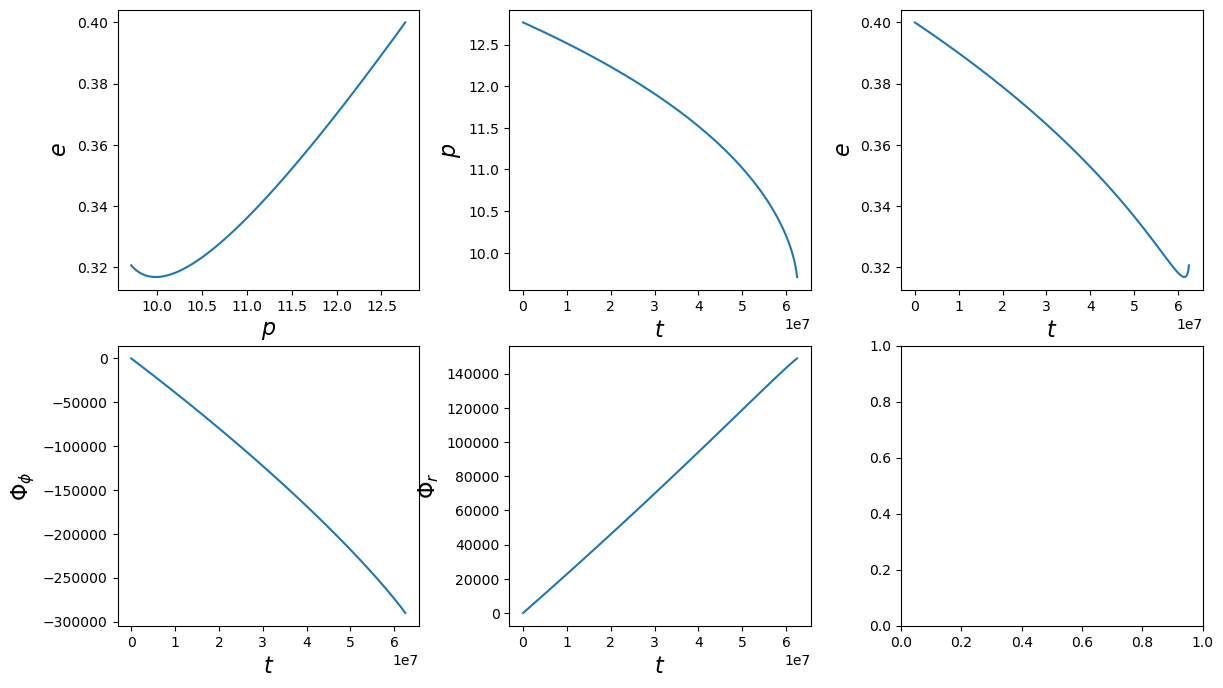

In [3]:
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$', r'Flux']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e, p, e, Phi_phi, Phi_r]
xs = [p, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

use gpus True
SNR 50.0


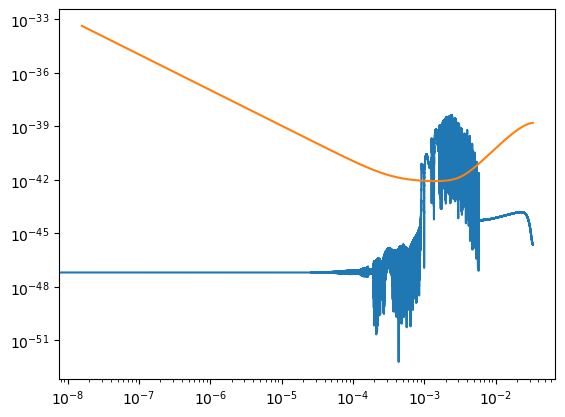

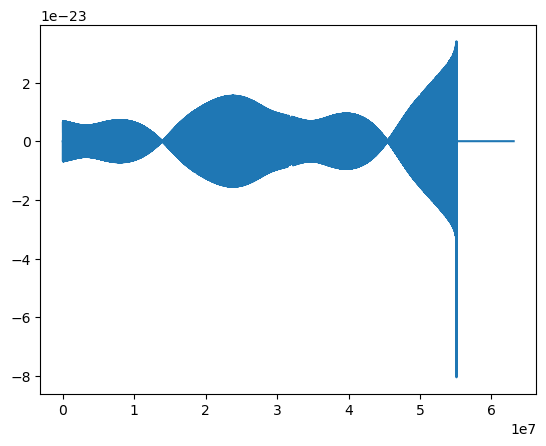

In [4]:
# sets the proper number of points and what not
print("use gpus",use_gpu)
N_obs = int(Tobs * YRSID_SI / dt) # may need to put "- 1" here because of real transform
Tobs = (N_obs * dt) / YRSID_SI
t_arr = xp.arange(N_obs) * dt

# frequencies
freqs = xp.fft.rfftfreq(N_obs, dt)


orbit_file_esa = "/data/lsperi/lisa-on-gpu/orbit_files/esa-trailing-orbits.h5"
orbit_kwargs_esa = dict(orbit_file=orbit_file_esa)

tdi_gen = "1st generation"

order = 25  # interpolation order (should not change the result too much)
tdi_kwargs_esa = dict(
    orbit_kwargs=orbit_kwargs_esa, order=order, tdi=tdi_gen, tdi_chan="AE",
)  # could do "AET"

index_lambda = 8
index_beta = 7

# with longer signals we care less about this
t0 = 20000.0  # throw away on both ends when our orbital information is weird

wave_gen = ResponseWrapper(
    few_gen,
    Tobs,
    dt,
    index_lambda,
    index_beta,
    t0=t0,
    flip_hx=True,  # set to True if waveform is h+ - ihx (FEW is)
    use_gpu=use_gpu,
    is_ecliptic_latitude=False,  # False if using polar angle (theta)
    remove_garbage="zero",  # removes the beginning of the signal that has bad information
    **tdi_kwargs_esa,
)
# wave_gen = few_gen

# for transforms
# this is an example of how you would fill parameters 
# if you want to keep them fixed
# (you need to remove them from the other parts of initialization)
fill_dict = {
   "ndim_full": 15,
   "fill_values": np.array([ emri_injection_params[5], 0.0]), # spin and inclination and Phi_theta
   "fill_inds": np.array([5, 12]),
}

(
    M,  
    mu,
    a, 
    p0, 
    e0, 
    x0,
    dist, 
    qS, # 7
    phiS,
    qK, 
    phiK, 
    Phi_phi0, 
    Phi_theta0, 
    Phi_r0,
    charge
) = emri_injection_params

# get the right parameters
# log of large mass
emri_injection_params[0] = np.log(emri_injection_params[0])
emri_injection_params[7] = np.cos(emri_injection_params[7]) 
emri_injection_params[8] = emri_injection_params[8] % (2 * np.pi)
emri_injection_params[9] = np.cos(emri_injection_params[9]) 
emri_injection_params[10] = emri_injection_params[10] % (2 * np.pi)

# remove three we are not sampling from (need to change if you go to adding spin)
emri_injection_params_in = np.delete(emri_injection_params, fill_dict["fill_inds"])

parameter_transforms = {
    0: np.exp,  # M 
    7: np.arccos, # qS
    9: np.arccos,  # qK
    14: np.exp
}

transform_fn = TransformContainer(
    parameter_transforms=parameter_transforms,
    fill_dict=fill_dict,

)

# get injected parameters after transformation
injection_in = transform_fn.both_transforms(emri_injection_params_in[None, :])[0]
# get AE
data_channels = wave_gen(*injection_in, **emri_kwargs)

check_snr = snr([data_channels[0], data_channels[1]],
    dt=dt,
    PSD="noisepsd_AE",
    PSD_args=(),
    PSD_kwargs={},
    use_gpu=use_gpu,
    )
dist_factor = check_snr.get() / 50.0

emri_injection_params[6] *= dist_factor
emri_injection_params_in = np.delete(emri_injection_params, fill_dict["fill_inds"])
# get injected parameters after transformation
injection_in = transform_fn.both_transforms(emri_injection_params_in[None, :])[0]
# get AE
data_channels = wave_gen(*injection_in, **emri_kwargs)

check_snr = snr([data_channels[0], data_channels[1]],
    dt=dt,
    PSD="noisepsd_AE",
    PSD_args=(),
    PSD_kwargs={},
    use_gpu=use_gpu,
    )

print("SNR",check_snr)

ffth = xp.fft.rfft(data_channels[0])
fft_freq = xp.fft.rfftfreq(len(data_channels[0]),dt)
PSD_arr = get_sensitivity(fft_freq, sens_fn="noisepsd_AE")

plt.figure()
plt.plot(fft_freq.get(), (xp.abs(ffth)**2).get())
plt.loglog(fft_freq.get(), PSD_arr.get())

plt.figure()
plt.plot(np.arange(len(data_channels[0].get()))*dt,  data_channels[0].get())